# Analysis of the Ethereum Blockchain Liquidations

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['font.size'] = 22

# Data Collection

The data consists of a list of arbitrage transactions, liquidations, block features which are stored on a postgres db.
Additionally, general features of the blockchain e.g. number of protocol usages in the transactions are stored in the db directory.
The arbitrage transactions were collected using calls to multiple Erigon RPC endpoints.

The first collection of data is from block 15200000 to 15500000 or from Jul-23-2022 04:32:35 PM +UTC to Sep-09-2022 01:39:42 AM +UTC.
These blocks are pre-merge blocks. The next collection will analyse the post-merge blocks.

First, we must connect to our database.

In [45]:
# Connect to db
from sqlalchemy import create_engine, text
from db import get_inspect_database_uri

conn = create_engine(get_inspect_database_uri()).connect()

# Liquidation Analysis

## Data Loading and Preprocessing

In [46]:
AFTER_BLOCK = 15200000
BEFORE_BLOCK = 15500000

In [47]:
query = f"SELECT * FROM liquidations WHERE block_number BETWEEN {AFTER_BLOCK} AND {BEFORE_BLOCK}"
liquidation_df = pd.DataFrame(conn.execute(text(query)))

In [48]:
liquidation_df.set_index('id', inplace=True)
liquidation_df['timestamp'] = pd.to_datetime(liquidation_df['timestamp'])
liquidation_df = liquidation_df.sort_values(by=['block_number', 'block_position'])

In [49]:
liquidation_df.head()

,transaction_hash,block_number,timestamp,trace_address,status,liquidated_user,liquidator_user,debt_token_address,debt_purchase_amount,received_amount,received_token_address,protocol,gas_price,gas_usage,block_position
id,,,,,,,,,,,,,,,
19,0x1741fa81f32954cc6385781da56fcbfaae8839959753...,15200838,2022-07-24 00:11:11,"{2,1,5}",True,0xcc603bec12aa268780cde4b852b1440ee7cf6b8b,0x8472ee188899569cf6ef42bb2038facae66972d2,0xdac17f958d2ee523a2206206994597c13d831ec7,123168435,86526557700677640,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,aave,2480101,488412,7
20,0x9f7b435bee2c2610c168d3f07351adeb4b8fba1c4b03...,15200853,2022-07-24 00:14:38,"{0,2,1}",True,0xaa9a8252421f801259e342f816f079e9e2d540fd,0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832,0xdac17f958d2ee523a2206206994597c13d831ec7,117923209,82841755258054296,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,aave,669628,502222,3
21,0x83ff1b8360c9ecf7f5e6aef01d02964132d81d53764d...,15200860,2022-07-24 00:15:13,"{0,2,2}",True,0x2e5b27a6ee216c90f6f42bfeadd7cd25888e5be3,0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832,0xdac17f958d2ee523a2206206994597c13d831ec7,72904649,261109595,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,compound_v2,693456,403409,1
22,0xd8d72681356931e895f555ff34fca07460f9360e0f4b...,15200873,2022-07-24 00:17:29,"{2,1,5}",True,0xf8b11cc89f0a12ddfa163865eeb168791aa03912,0x8472ee188899569cf6ef42bb2038facae66972d2,0xdac17f958d2ee523a2206206994597c13d831ec7,137103234,22047935724083990666,0x514910771af9ca656af840dff83e8264ecf986ca,aave,3287587,605587,15
23,0xf828ee8a42b88a352f65f41698f77718e9e07c1e27aa...,15200873,2022-07-24 00:17:29,"{0,2,2}",True,0x334ca9fa33b2560a0fc6cdb2e5b95a28ea3005ed,0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,91220273,445905,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,aave,2546646,483353,16


In [50]:
liquidation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1859 entries, 19 to 1656
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_hash        1859 non-null   object        
 1   block_number            1859 non-null   int64         
 2   timestamp               1859 non-null   datetime64[ns]
 3   trace_address           1859 non-null   object        
 4   status                  1859 non-null   bool          
 5   liquidated_user         1859 non-null   object        
 6   liquidator_user         1859 non-null   object        
 7   debt_token_address      1859 non-null   object        
 8   debt_purchase_amount    1859 non-null   object        
 9   received_amount         1859 non-null   object        
 10  received_token_address  1859 non-null   object        
 11  protocol                1859 non-null   object        
 12  gas_price               1859 non-null   int64  

## Status Analysis

Get the success rate of each liquidator and protocol.

In [51]:
def count_features_grouped_by(df: pd.DataFrame, condition: str, _by: [str], features: [str]) -> pd.DataFrame:
    return df.loc[eval(condition)].groupby(by=_by).count().reset_index()[features]

### By Address

Get the success rate of each address

In [52]:
liquidator_success_rate = liquidation_df.groupby('liquidator_user')['status'].mean()
print('Success rate of each address:')
liquidator_success_rate.head()

Success rate of each address:


liquidator_user
0x00000000000a47b1298f18cf67de547bbe0d723f    1.0
0x01055e98e388005ef68f440f3ed99ac0583864b2    1.0
0x01218bfba4354a5f2a382240e5d5ff30a1e3a5d7    1.0
0x04c3256c1328b5d685916de07bb1f721b06b966a    1.0
0x04eb85ad427e7e6b3ffb67e049872210fd3fbae9    1.0
Name: status, dtype: float64

### By Protocol
Get the success rate of each protocol


In [53]:
protocols_df = liquidation_df["protocol"].str.get_dummies()

# Concatenate the status column and the protocol columns
merged_df = pd.concat([liquidation_df["status"], protocols_df], axis=1)

# Calculate the success rate for each protocol
rates_df = merged_df.mean()
rates_df = rates_df.drop("status")

rates_df

aave           0.707907
compound_v2    0.292093
dtype: float64

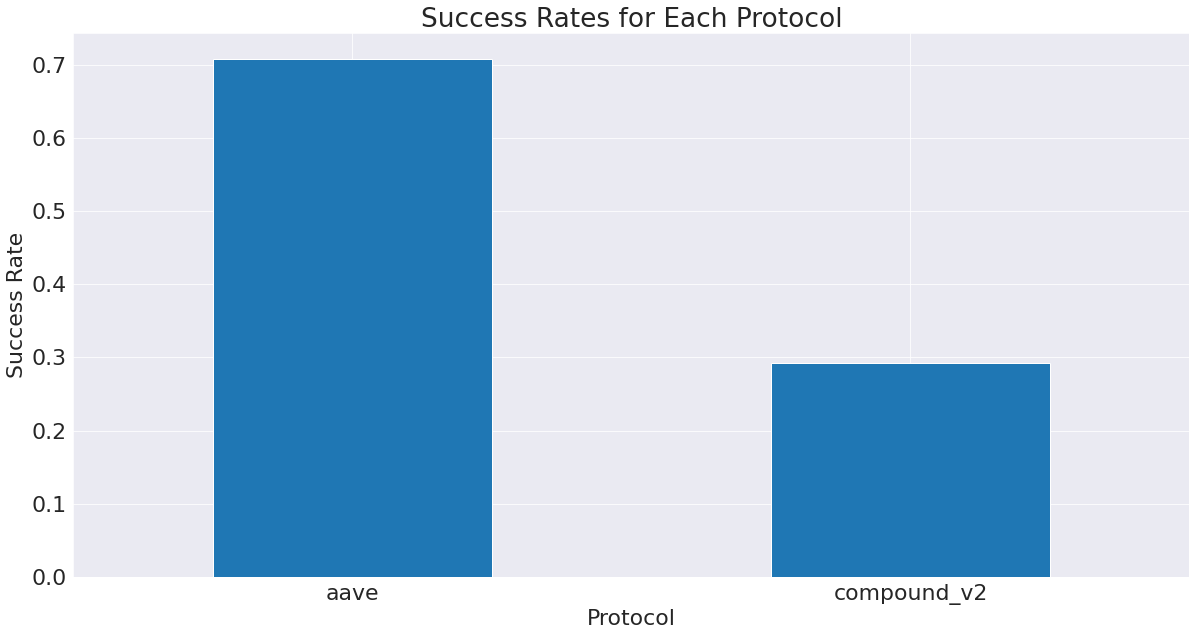

In [54]:
plt.figure(figsize=(20, 10))
rates_df.plot(kind="bar", rot=0)
plt.title("Success Rates for Each Protocol")
plt.xlabel("Protocol")
plt.ylabel("Success Rate")
plt.show()

## Gas Usage Analysis

### Distribution

### Average gas usage per block
Compare average gas price for liquidation transactions in each block with the total average gas price of that block.

First, load the blocks' data.

In [55]:
# TODO: Log-transformation for heavy-tailed features
query = f"SELECT * FROM blocks WHERE block_number BETWEEN {AFTER_BLOCK} AND {BEFORE_BLOCK}"
block_df = pd.DataFrame(conn.execute(text(query)))
block_df = block_df.sort_values(by=['block_number'])
block_df

,block_number,avg_gas_price,avg_gas_usage
20,15200000,3.709889e+10,114012.008000
21,15200001,3.320040e+10,123304.953668
22,15200002,3.510495e+10,82396.833333
23,15200003,3.190219e+10,130569.504762
24,15200004,3.724912e+10,144287.694444
...,...,...,...
282170,15499995,1.805299e+10,168087.592593
282171,15499996,2.003297e+10,157698.281818
282172,15499997,1.865771e+10,119595.007220
282173,15499998,2.002910e+10,154689.847273


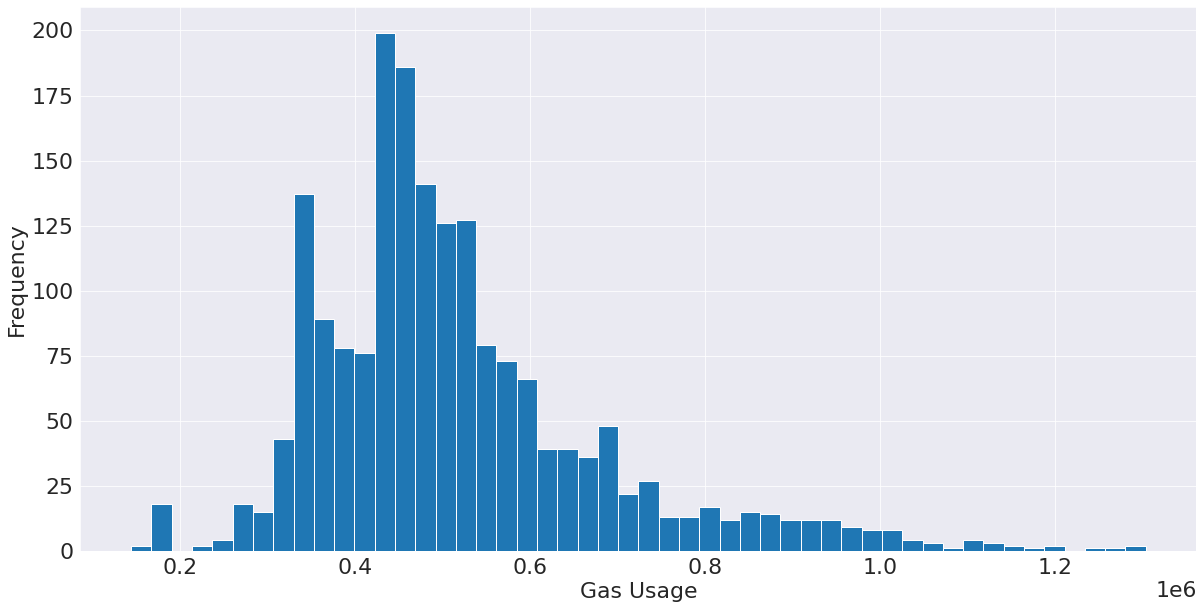

In [56]:
# Gas usage distribution

plt.figure(figsize=(20, 10))
plt.hist(liquidation_df['gas_usage'], bins=50)
plt.xlabel('Gas Usage')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

In [57]:
avg_gas_per_block = liquidation_df.groupby('block_number')['gas_usage'].mean()

In [58]:
# merge the average gas usage per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

,block_number,avg_gas_price,avg_gas_usage,gas_usage
0,15200838,1.050256e+10,272774.485714,488412.0
1,15200853,1.784955e+10,209985.777778,502222.0
2,15200860,1.058887e+10,138880.707317,403409.0
3,15200873,1.116792e+10,198641.255973,544470.0
4,15200885,9.779194e+09,207169.605263,438604.0
...,...,...,...,...
1409,15489340,7.715643e+09,340029.435897,657055.0
1410,15489351,9.031621e+09,219696.260000,441739.0
1411,15489366,1.044738e+10,178888.331620,360223.0
1412,15493150,1.108956e+10,200693.397476,311508.0


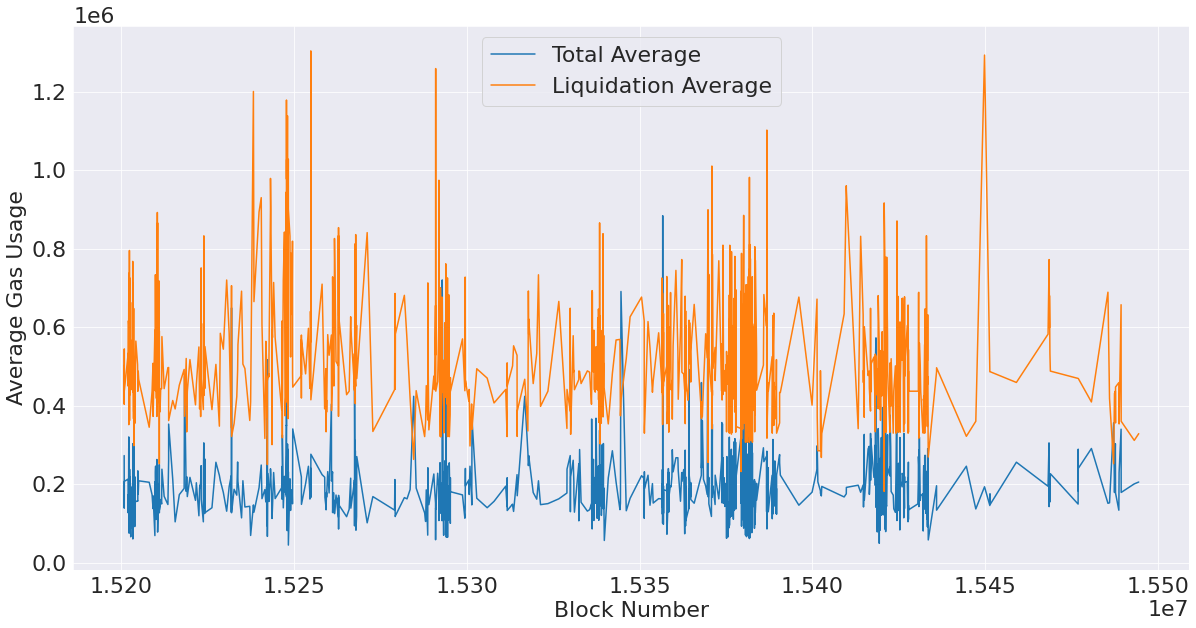

In [59]:
# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(20, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_usage'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_usage'], label='Liquidation Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Usage')
plt.legend()
plt.show()

## Gas Price Analysis

### Distribution

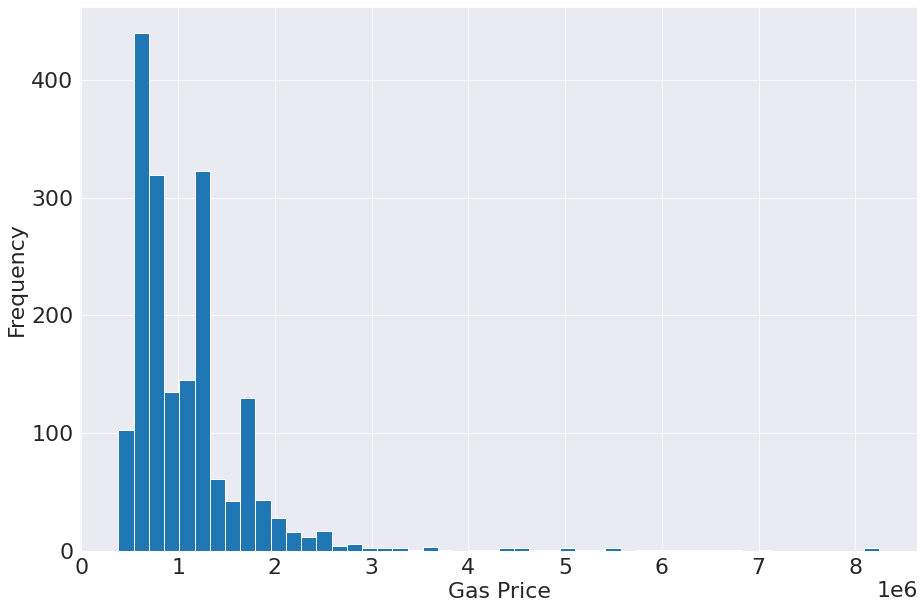

In [60]:
# Gas usage distribution

plt.figure(figsize=(15, 10))
plt.hist(liquidation_df['gas_price'], bins=50)
plt.xlabel('Gas Price')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

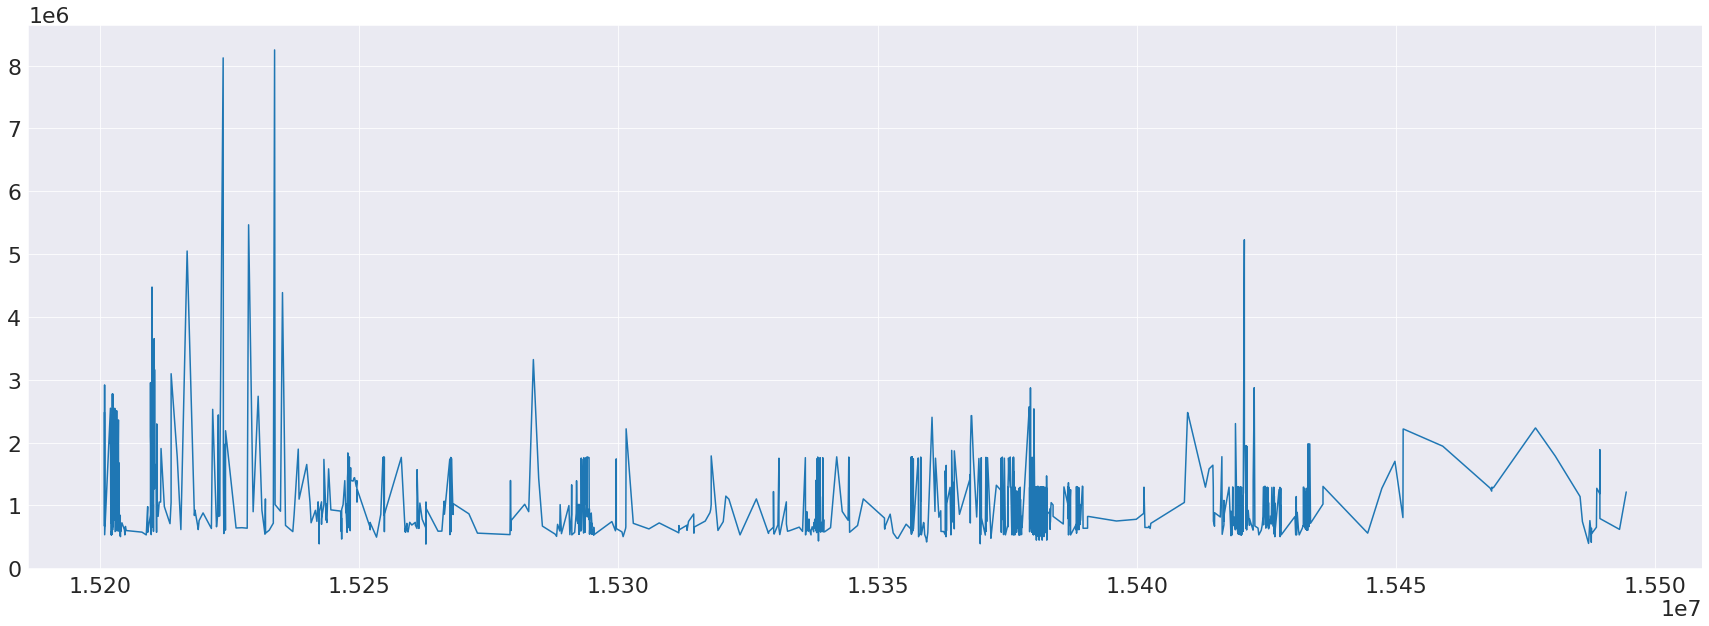

In [61]:
avg_gas_per_block = liquidation_df.groupby('block_number')['gas_price'].mean()
# merge the average gas price per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

plt.figure(figsize=(30, 10))
plt.plot(merged_df['block_number'], merged_df['gas_price'], label='Liquidation Average')
plt.show()

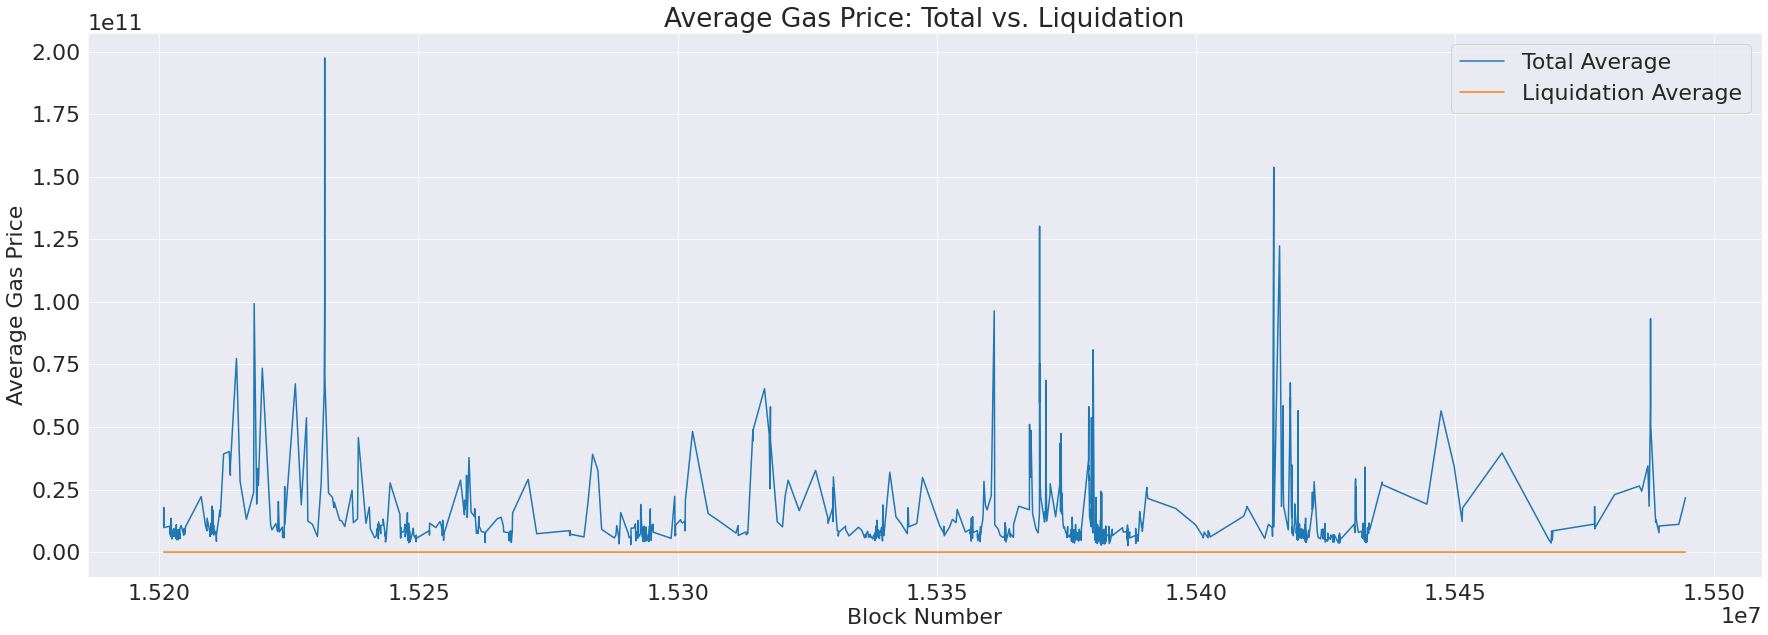

In [62]:
# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(30, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_price'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_price'], label='Liquidation Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Price')
plt.title("Average Gas Price: Total vs. Liquidation")
plt.legend()
plt.show()

# Analysis of the Tokens

In [63]:
from collections import Counter


def _address_use(token_column: str):
    all_sets = pd.concat([liquidation_df[token_column]])
    all_strings = [string for set_ in all_sets for string in set_.split(',')]
    counts = Counter(all_strings)

    return pd.DataFrame(counts.values(), index=counts.keys(), columns=['count'])

In [64]:
debt_tokens = _address_use('debt_token_address')
received_tokens = _address_use('received_token_address')

In [65]:
from tokens.name_tags import get_name_tag


def _get_name_tags(addresses):
    _public_name_tags = {}

    for address in addresses:
        _public_name_tags[address] = get_name_tag(_address=address)

    return _public_name_tags

In [66]:
def plot_tokens_usage(tokens, _type):
    most_used_tokens = tokens.nlargest(10, tokens.columns[0])
    token_name_tags = _get_name_tags(most_used_tokens.index)

    x = most_used_tokens.index.map(token_name_tags)

    plt_fig, _ax = plt.subplots(figsize=(20, 10))
    _ax.bar(x, most_used_tokens.values.squeeze(), width=0.4)
    _ax.set_xticks(x)
    _ax.set_xticklabels(x, rotation=60, ha='right')

    _ax.set_title(f"Most used {_type} tokens for liquidation")

    _ax.set_xlabel("token public name tag")
    _ax.set_ylabel('number of liquidations', labelpad=15)

    plt.show()

INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Tether: USDT Stablecoin
INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Null: 0xeee...eee
INFO:root:Already found: TrueUSD: TUSD Token
INFO:root:Already found: Binance USD
INFO:root:Already found: Ampleforth: AMPL Token
INFO:root:Already found: Gemini: GUSD Token
INFO:root:Already found: Sai Stablecoin


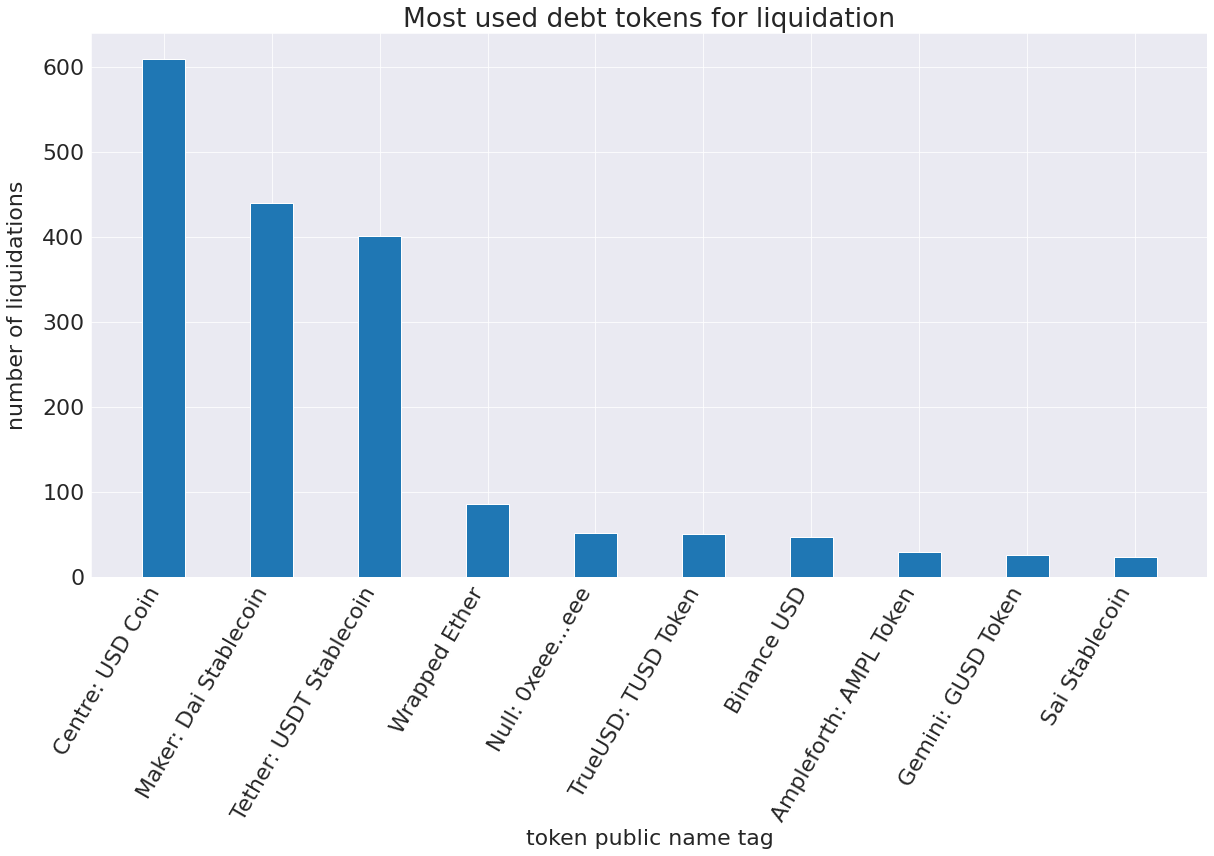

In [67]:
plot_tokens_usage(debt_tokens, "debt")

INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Compound: cETH Token
INFO:root:Already found: Chainlink: LINK Token
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Compound: cUNI Token
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Already found: Compound: cCOMP Token
INFO:root:Already found: Lido: stETH Token
INFO:root:Already found: Null: 0xeee...eee
INFO:root:Already found: Aave: aWETH Token V2


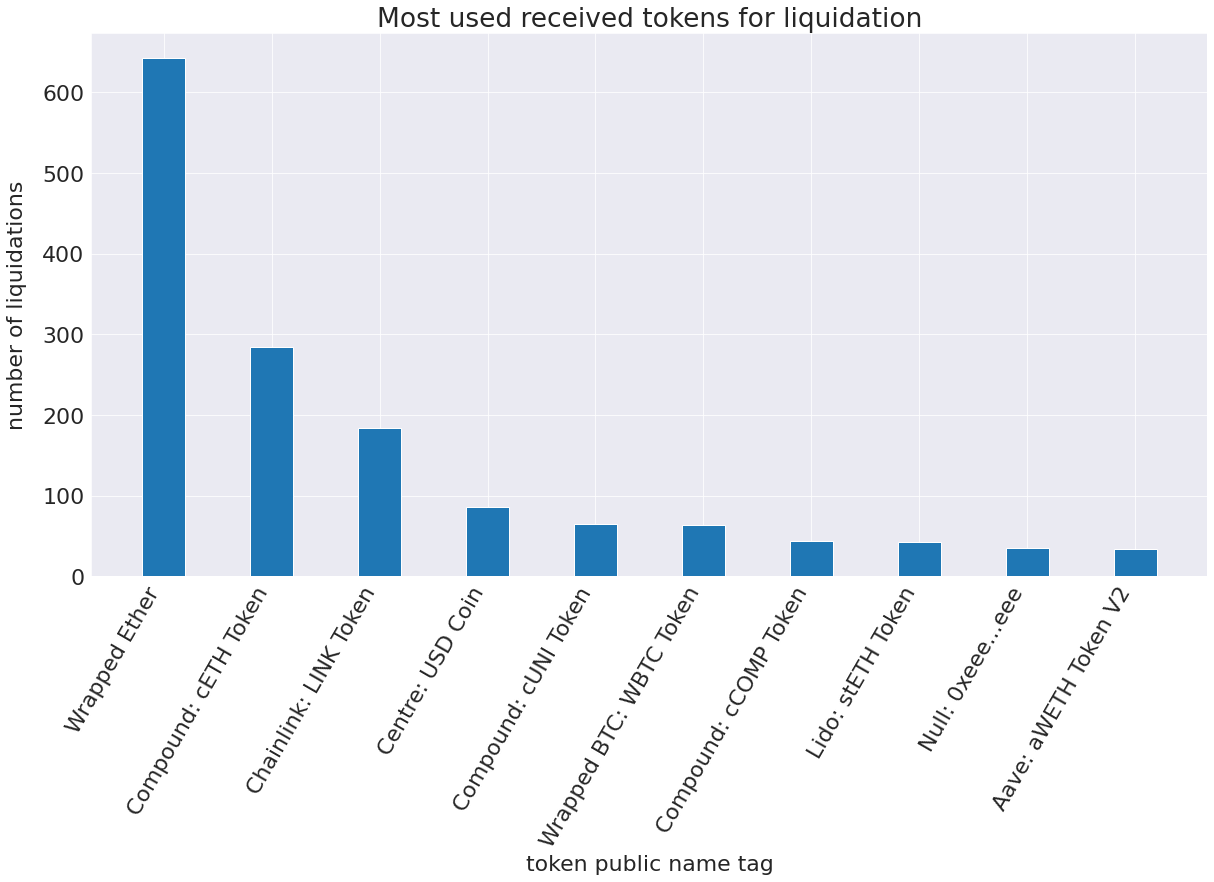

In [68]:
plot_tokens_usage(received_tokens, "received")

The most used token is WETH. This is because arbitrageurs usually buy an arbitrage asset using ETH and gain the profit by selling them in ETH.
This might be because the WETH-TOKEN pools are more common in the exchanges.
The two latter places belong to stable coins: USDC and USDT
The three Shiba INu tokens: BONE, SHIB, and LEASH are also on top of the list.
Note that originally we only stored and counted the profit token which is usually WETH. But as mentioned before, the arbitrage opportunity is not a result of instability in WETH, rather in the instability of a certain token which is then exploited using the WETH pool.


## Active Addresses Analysis

### Most Active Addresses

In this part we take a look at the most active liquidators i.e. the addresses that have the largest number of liquidation transactions.
We can use this data along with the most profitable addresses to see if there is any relation between number of transactions and profit.

The distribution of the number of transactions by address

INFO:root:Already found: MEV Bot: 0x9A0...832
INFO:root:Already found: Contract Address 0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8
INFO:root:Already found: Contract Address 0x6f52f5f8ac30a5079a1e96862d67814de2abc1e1
INFO:root:Already found: MEV Bot: 0x847...2d2
INFO:root:Already found: Contract Address 0x258fdfce1524b0eb30f127e9099e7e75959f71aa
INFO:root:Already found: MEV Bot: 0xD91...C6F
INFO:root:Already found: Address 0x4cd62db8e2d78db8138e4d6e0d65cf76ff2a3b85
INFO:root:Already found: Contract Address 0xa090e6e0311ce8fe1f9d7c16921861661097f6a6
INFO:root:Already found: Contract Address 0xa4851773969f0e594dbd50d9e98de72cb89cf6e8
INFO:root:Already found: Contract Address 0xe9c7c1d88bb8cc694d2999d6e49ecffcb8a97c10


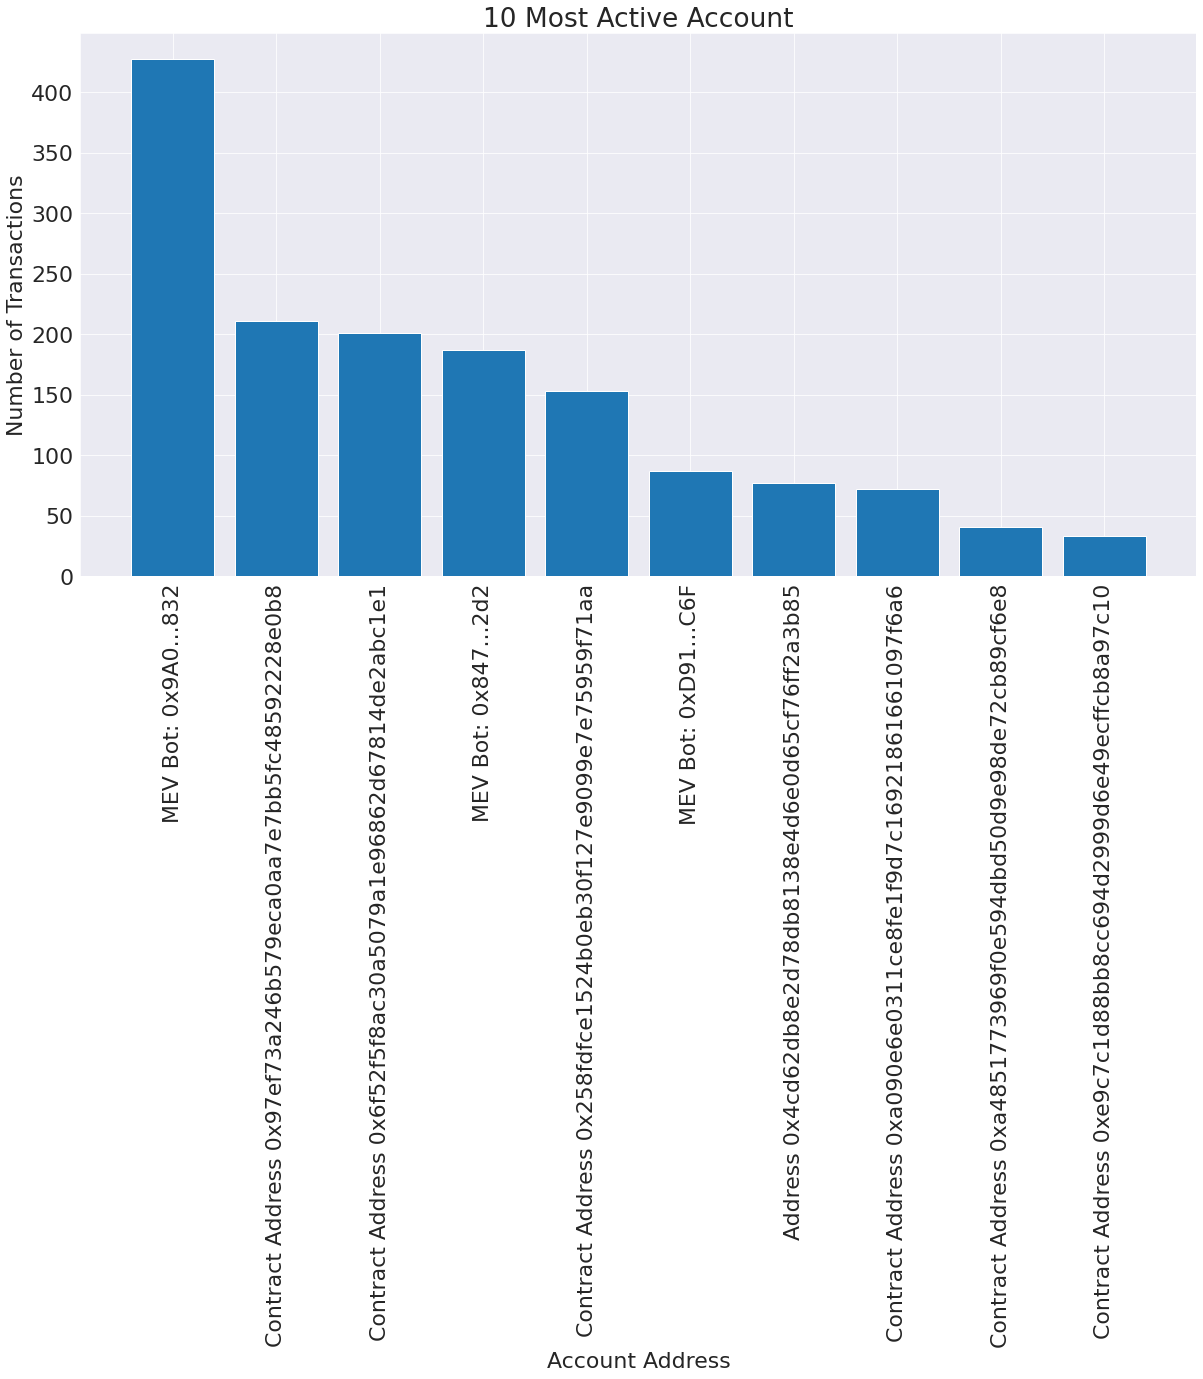

In [69]:
# Count the number of transactions for each account address
transactions_by_address = liquidation_df['liquidator_user'].value_counts()
account_name_tags = _get_name_tags(transactions_by_address.head(10).index)

# Plot the results as a bar chart
plt.figure(figsize=(20, 10))
plt.bar(transactions_by_address.head(10).index.map(account_name_tags), transactions_by_address.head(10))
plt.title('10 Most Active Account')
plt.xlabel('Account Address')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)
plt.show()

### Distribution

The distribution of the number of transactions per address.

Note: Addresses with less than 5 transactions were removed. There were around 300 accounts.

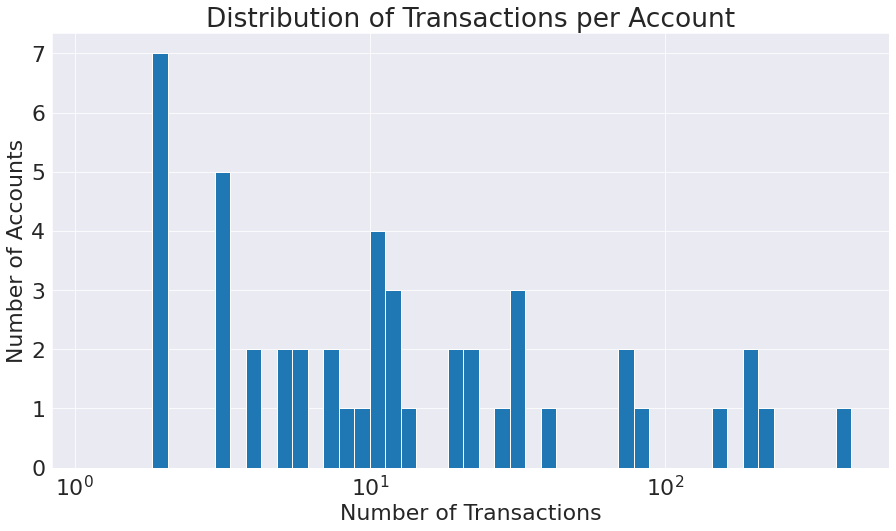

In [70]:
# Group by account address and count the number of transactions
transactions_per_account = liquidation_df.groupby(['liquidator_user']).size()

# Define custom bin edges
bin_edges = np.logspace(np.log10(1), np.log10(transactions_per_account.max()), 51)

# Remove the first bin edge
bin_edges = bin_edges[1:]

# Plot the distribution of transactions per account as a histogram
plt.figure(figsize=(15, 8))
plt.hist(transactions_per_account, bins=bin_edges)
plt.xscale('log')
plt.title('Distribution of Transactions per Account')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Accounts')
plt.show()

## Ratio of arbitrage transactions

What's the ratio of arbitrage transactions to all transactions for the top 20 addresses?

In [71]:
top_addresses = transactions_by_address.head(20)
top_addresses

0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832    428
0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8    211
0x6f52f5f8ac30a5079a1e96862d67814de2abc1e1    201
0x8472ee188899569cf6ef42bb2038facae66972d2    187
0x258fdfce1524b0eb30f127e9099e7e75959f71aa    153
0xd911560979b78821d7b045c79e36e9cbfc2f6c6f     87
0x4cd62db8e2d78db8138e4d6e0d65cf76ff2a3b85     77
0xa090e6e0311ce8fe1f9d7c16921861661097f6a6     72
0xa4851773969f0e594dbd50d9e98de72cb89cf6e8     41
0xe9c7c1d88bb8cc694d2999d6e49ecffcb8a97c10     33
0xb206ebe579be55f5b57119bb2e7cc63708eda1aa     31
0x04c3256c1328b5d685916de07bb1f721b06b966a     30
0x5cb6b2844451cc4a46784a8dce0ab12844c00972     27
0x3c02dc67a944c638903cef2510902efd7cc10711     23
0xf30087bbf02155abda1a162a29e97fcc41370288     21
0x07197a25bf7297c2c41dd09a79160d05b6232bcf     20
0xabcf5d4be599f1c7f71fcbcae4643a2aa849f4c8     19
0x00000000000a47b1298f18cf67de547bbe0d723f     14
0x625d6d3f3b375e686642dc8d1d438ac58058d09c     12
0x098fb667782f755501622b40110f1081d6180026     12


## Time-Series Analysis of Arbitrage Transactions

In [72]:
timed_liq_df = liquidation_df.set_index('timestamp', inplace=False)

daily_liq = timed_liq_df.resample('D')

In [73]:
daily_summary = daily_liq.agg({
    'transaction_hash': 'count',
    'block_number': ['min', 'max'],
    'liquidator_user': pd.Series.nunique,
    'liquidated_user': pd.Series.nunique,
    'status': 'sum',
    'gas_price': ['min', 'max', 'mean', 'sum'],
    'gas_usage':  ['min', 'max', 'mean', 'sum'],
    'block_position': ['min', 'max', 'mean'],
    'debt_purchase_amount': ['min', 'max', 'mean', 'sum'],
    'received_amount': ['min', 'max', 'mean', 'sum']
})

daily_summary

transaction_hash block_number             liquidator_user  \
                      count          min         max         nunique   
timestamp                                                              
2022-07-24              144   15200838.0  15205038.0               9   
2022-07-25               49   15208080.0  15213492.0              11   
2022-07-26               12   15213704.0  15219871.0               8   
2022-07-27               42   15221477.0  15226238.0               6   
2022-07-28               14   15227384.0  15232648.0               5   
2022-07-29               10   15233425.0  15238397.0               7   
2022-07-30               47   15239870.0  15244525.0              11   
2022-07-31              125   15246411.0  15252141.0              12   
2022-08-01               16   15253337.0  15258114.0               7   
2022-08-02               40   15258863.0  15262915.0               8   
2022-08-03               40   15265207.0  15271160.0               9   
2022-08-04                1   15272810.0  15272810.0               1   
2022-08-05               10   15279087.0  15283596.0               5   
2022-08-06               15   15284620.0  15290453.0               6   
2022-08-07               95   15290638.0  15295256.0               8   
2022-08-08               13   15298744.0  15302878.0               5   
2022-08-09                2   15305890.0  15307873.0               2   
2022-08-10               10   15311256.0  15314587.0               3   
2022-08-11                9   15316755.0  15321322.0               6   
2022-08-12                2   15323467.0  15326617.0               2   
2022-08-13               15   15328968.0  15334885.0               6   
2022-08-14               72   15335528.0  15340934.0               5   
2022-08-15                7   15342119.0  15347253.0               5   
2022-08-16               10   15350567.0  15353933.0               5   
2022-08-17               49   15355513.0  15360508.0               7   
2022-08-18               33   15361080.0  15365797.0               6   
2022-08-19               40   15367866.0  15372919.0              12   
2022-08-20              122   15373737.0  15379445.0              16   
2022-08-21              382   15379476.0  15385830.0              16   
2022-08-22               73   15385963.0  15390732.0               9   
2022-08-23                1   15396089.0  15396089.0               1   
2022-08-24                8   15399914.0  15402723.0               4   
2022-08-25                3   15409194.0  15409838.0               2   
2022-08-26               15   15413254.0  15416901.0               8   
2022-08-27              125   15417810.0  15423401.0              17   
2022-08-28               95   15423557.0  15427879.0              10   
2022-08-29               72   15430526.0  15433535.0              10   
2022-08-30                2   15435938.0  15435942.0               2   
2022-08-31                2   15444563.0  15447295.0               2   
2022-09-01                4   15449819.0  15451481.0               2   
2022-09-02                1   15459041.0  15459041.0               1   
2022-09-03                0          NaN         NaN               0   
2022-09-04                8   15468206.0  15468873.0               2   
2022-09-05                5   15476900.0  15476953.0               1   
2022-09-06                3   15480751.0  15485536.0               3   
2022-09-07               14   15485994.0  15489366.0              10   
2022-09-08                2   15493150.0  15494444.0               1   

           liquidated_user status  gas_price                           \
                   nunique    sum        min        max          mean   
timestamp                                                               
2022-07-24             136    144   502777.0  3287587.0  1.450635e+06   
2022-07-25              45     49   530504.0  4475169.0  1.564017e+06   
2022-07-26              12     12   615110.0 

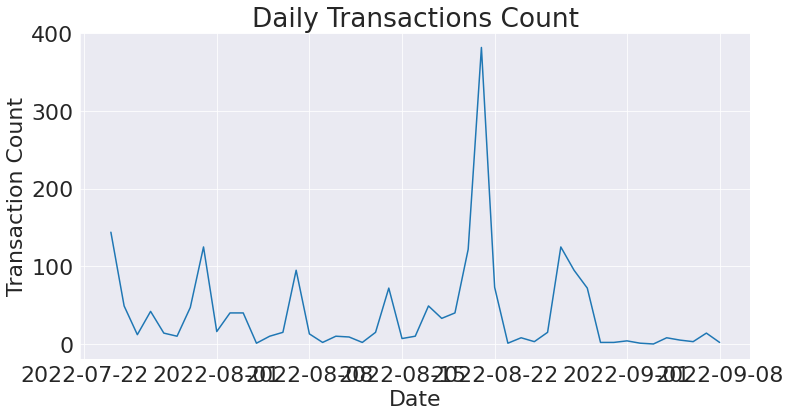

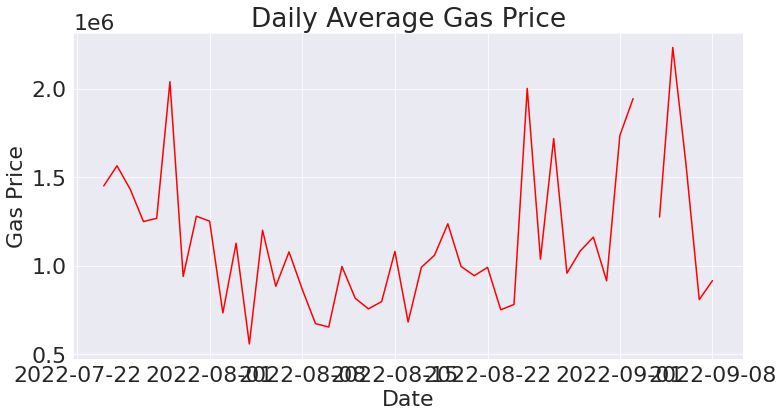

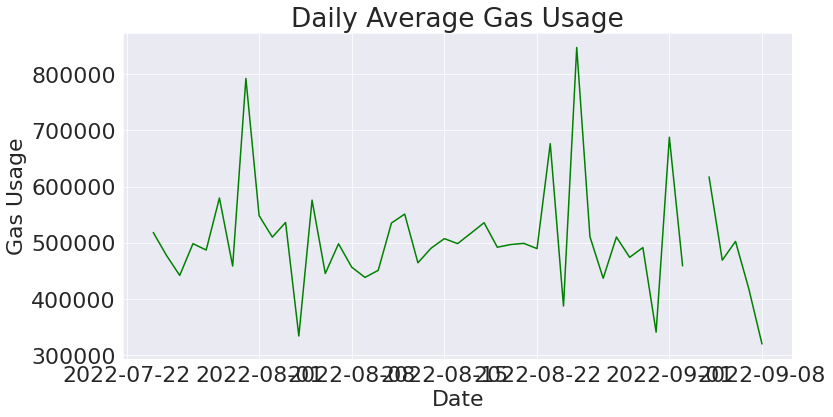

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['transaction_hash', 'count'])
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transactions Count')

plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['gas_price', 'mean'], color='red')
plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.title('Daily Average Gas Price')

plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['gas_usage', 'mean'], color='green')
plt.xlabel('Date')
plt.ylabel('Gas Usage')
plt.title('Daily Average Gas Usage')

plt.show()

## Time-Series Analysis of Accounts

In [75]:
def plot_address_activity(_address, color, _column):
    address_mask = timed_liq_df[_column].str.split(',').apply(lambda x: _address in x)
    address_df = timed_liq_df[address_mask]
    daily_tx_count = address_df.groupby(pd.Grouper(freq='D')).agg({'transaction_hash': 'count'})
    plt.plot(daily_tx_count.index, daily_tx_count['transaction_hash'], color=color)
    max_tx_count = daily_tx_count['transaction_hash'].max()
    max_tx_date = daily_tx_count['transaction_hash'].idxmax().strftime('%Y-%m-%d')
    print(f"{_address}: {max_tx_date}, {max_tx_count}")

0x9a0ef593dcc6a77f80699c9fa00d1e138b67d832: 2022-08-21, 83
0x97ef73a246b579eca0aa7e7bb5fc48592228e0b8: 2022-08-21, 69
0x6f52f5f8ac30a5079a1e96862d67814de2abc1e1: 2022-08-21, 59
0x8472ee188899569cf6ef42bb2038facae66972d2: 2022-08-21, 66
0x258fdfce1524b0eb30f127e9099e7e75959f71aa: 2022-08-21, 77


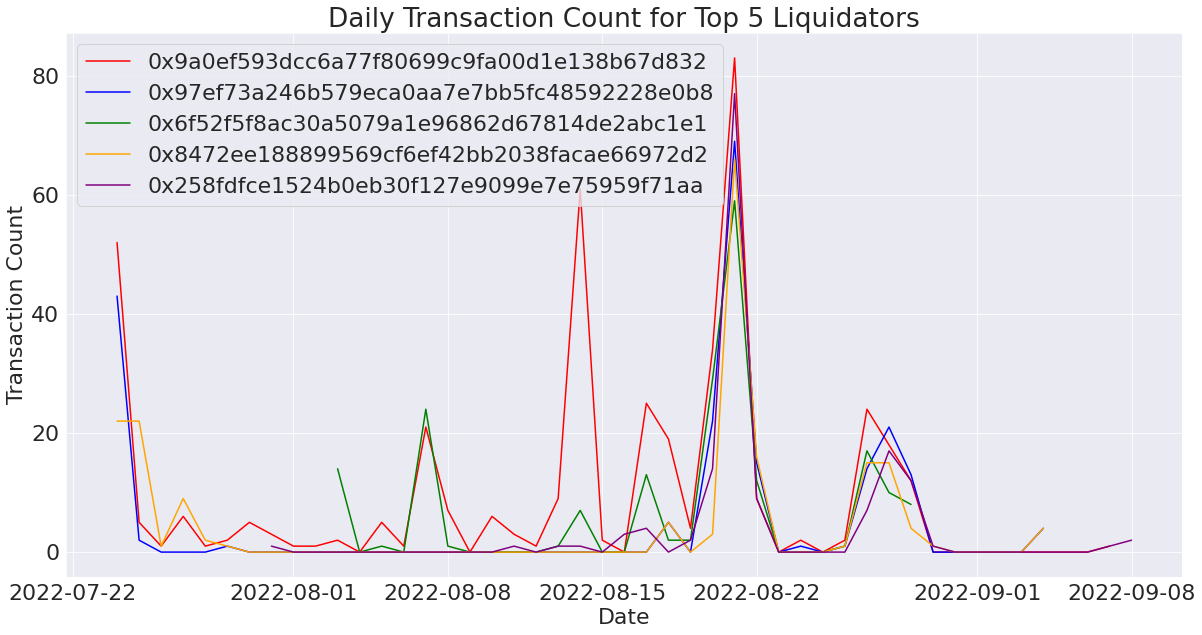

In [76]:
colors = ['red', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(20,10))
for i, account_address in enumerate(top_addresses.head(5).index):
    plot_address_activity(_address=account_address, color=colors[i], _column='liquidator_user')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Top 5 Liquidators')
plt.legend(top_addresses.head(5).index, loc='best')
plt.show()

## Time-Series Analysis of Tokens

INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Tether: USDT Stablecoin
INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Null: 0xeee...eee
INFO:root:Already found: TrueUSD: TUSD Token
INFO:root:Already found: Binance USD
INFO:root:Already found: Ampleforth: AMPL Token
INFO:root:Already found: Gemini: GUSD Token
INFO:root:Already found: Sai Stablecoin
INFO:root:Already found: Synthetix: Proxy sUSD Token
INFO:root:Already found: Paxos: USDP Token
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Already found: Fei Protocol: FEI Token
INFO:root:Already found: 0x: ZRX Token
INFO:root:Already found: Synthetix: Proxy SNX Token
INFO:root:Already found: Chainlink: LINK Token
INFO:root:Already found: Basic Attention: BAT Token
INFO:root:Already found: Frax Finance: FRAX Token
INFO:root:Already found: Uniswap Protocol: UNI token
0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48: 2022-08-21, 144
0x6b175474e89094c44

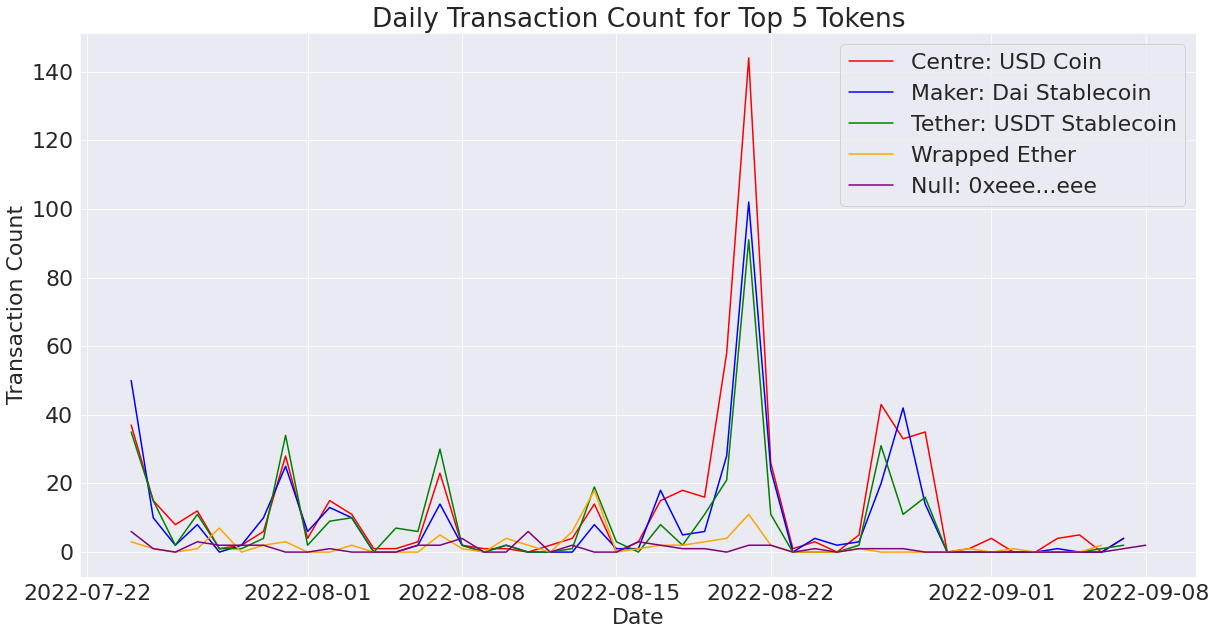

In [77]:
def plot_tokens_tx_cnt(tokens, _column):
    most_used_tokens = tokens.nlargest(20, tokens.columns[0])
    token_name_tags = _get_name_tags(most_used_tokens.index)

    plt.figure(figsize=(20,10))
    for i, token_address in enumerate(most_used_tokens.head(5).index):
        plot_address_activity(_address=token_address, color=colors[i], _column=_column)

    plt.xlabel('Date')
    plt.ylabel('Transaction Count')
    plt.title('Daily Transaction Count for Top 5 Tokens')
    plt.legend(most_used_tokens.index.map(token_name_tags), loc='best')
    plt.show()

plot_tokens_tx_cnt(debt_tokens, 'debt_token_address')

INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Compound: cETH Token
INFO:root:Already found: Chainlink: LINK Token
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Compound: cUNI Token
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Already found: Compound: cCOMP Token
INFO:root:Already found: Lido: stETH Token
INFO:root:Already found: Null: 0xeee...eee
INFO:root:Already found: Aave: aWETH Token V2
INFO:root:Already found: Aave: AAVE Token
INFO:root:Already found: Compound: cWBTC2 Token
INFO:root:Already found: Uniswap Protocol: UNI token
INFO:root:Already found: Compound: cUSDC Token
INFO:root:Already found: Compound: cZRX Token
INFO:root:Already found: Compound: cLink Token
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Compound: cBAT Token
INFO:root:Already found: Ygov.finance: YFI Token
INFO:root:Already found: Compound: cWBTC Token
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2: 2022-08-21, 158
0x4ddc2d193948926d02

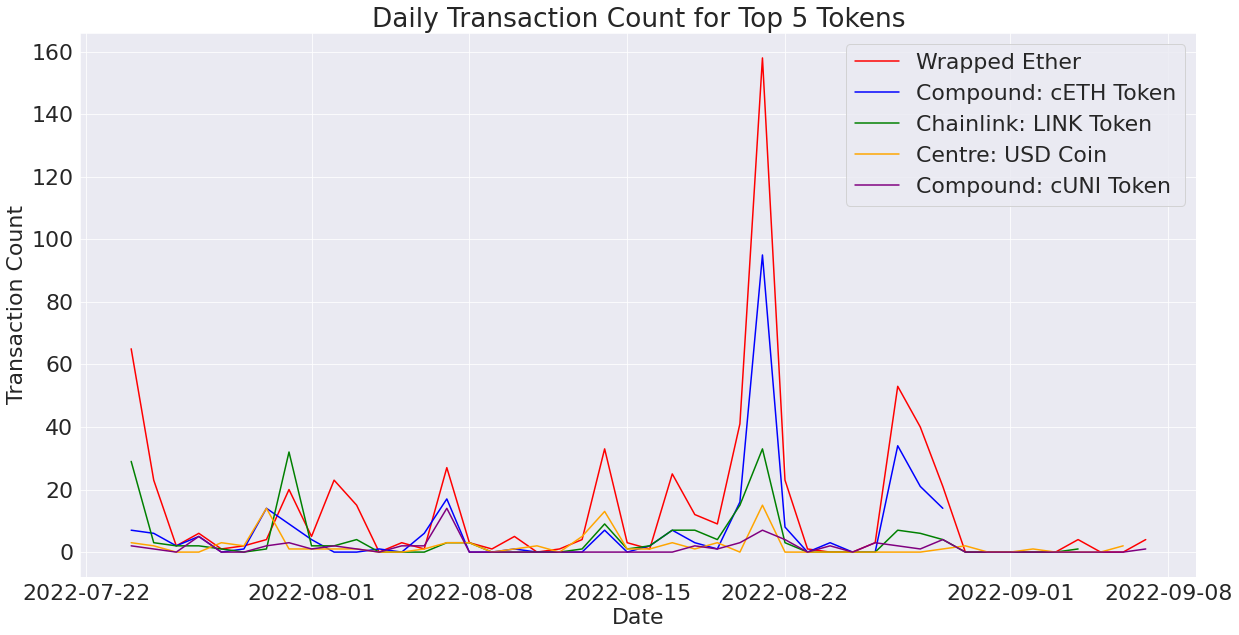

In [78]:
plot_tokens_tx_cnt(received_tokens, "received_token_address")

aave: 2022-08-21, 266
compound_v2: 2022-08-21, 116


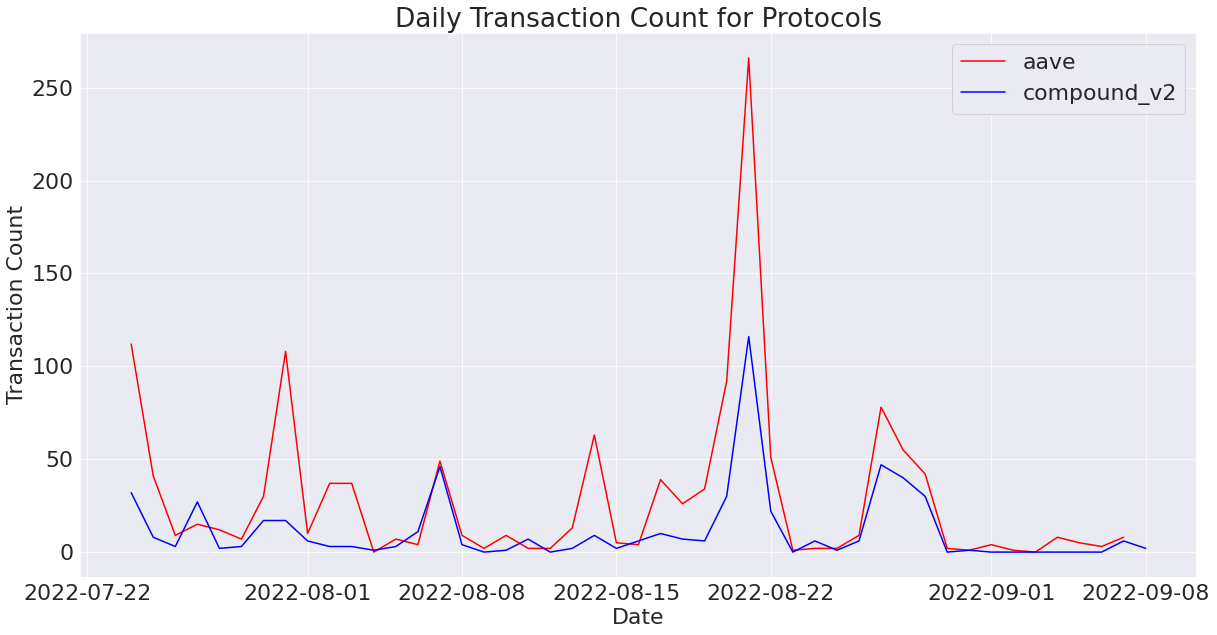

In [79]:
# liquidation_df["protocol"].str.get_dummies()

protocols = liquidation_df['protocol'].reset_index(level=0, drop=True).to_frame('protocol')['protocol'].unique()

plt.figure(figsize=(20,10))
for i, protocol in enumerate(protocols):
    plot_address_activity(_address=protocol, color=colors[i], _column='protocol')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Protocols')
plt.legend(protocols, loc='best')
plt.show()

## Block position

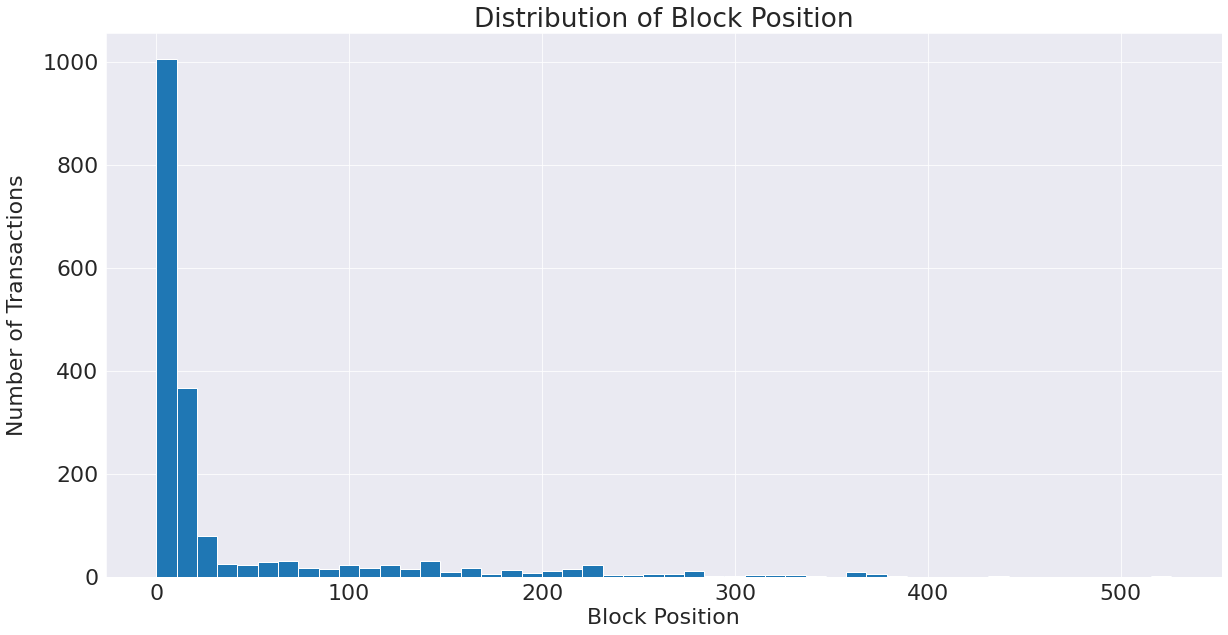

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

liquidation_df['block_position'].hist(bins=50, ax=ax)

ax.set_title('Distribution of Block Position')

ax.set_xlabel('Block Position')
ax.set_ylabel('Number of Transactions', labelpad=15)

plt.show()

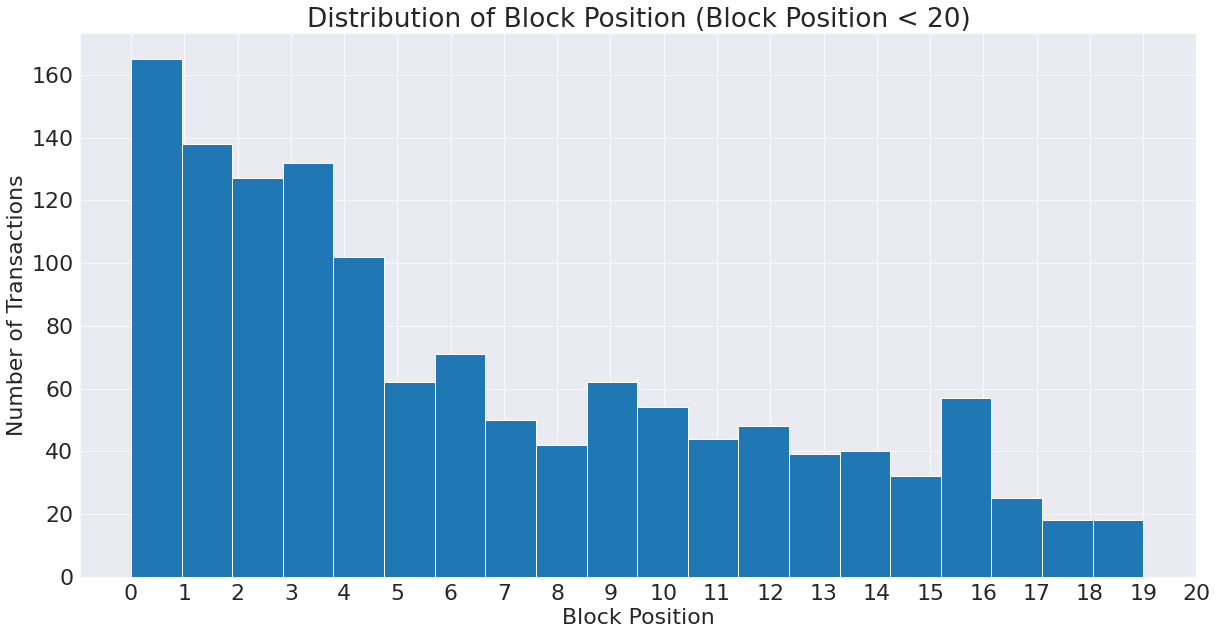

In [81]:
# Filter the data to include only block positions less than 20
filtered_df = liquidation_df[liquidation_df['block_position'] < 20]

# Plot the distribution of block_position less than 20 as a histogram
plt.figure(figsize=(20,10))
filtered_df['block_position'].hist(bins=20)
plt.title('Distribution of Block Position (Block Position < 20)')
plt.xlabel('Block Position')
plt.ylabel('Number of Transactions')
plt.xticks(np.arange(21))
plt.show()

## Protocols

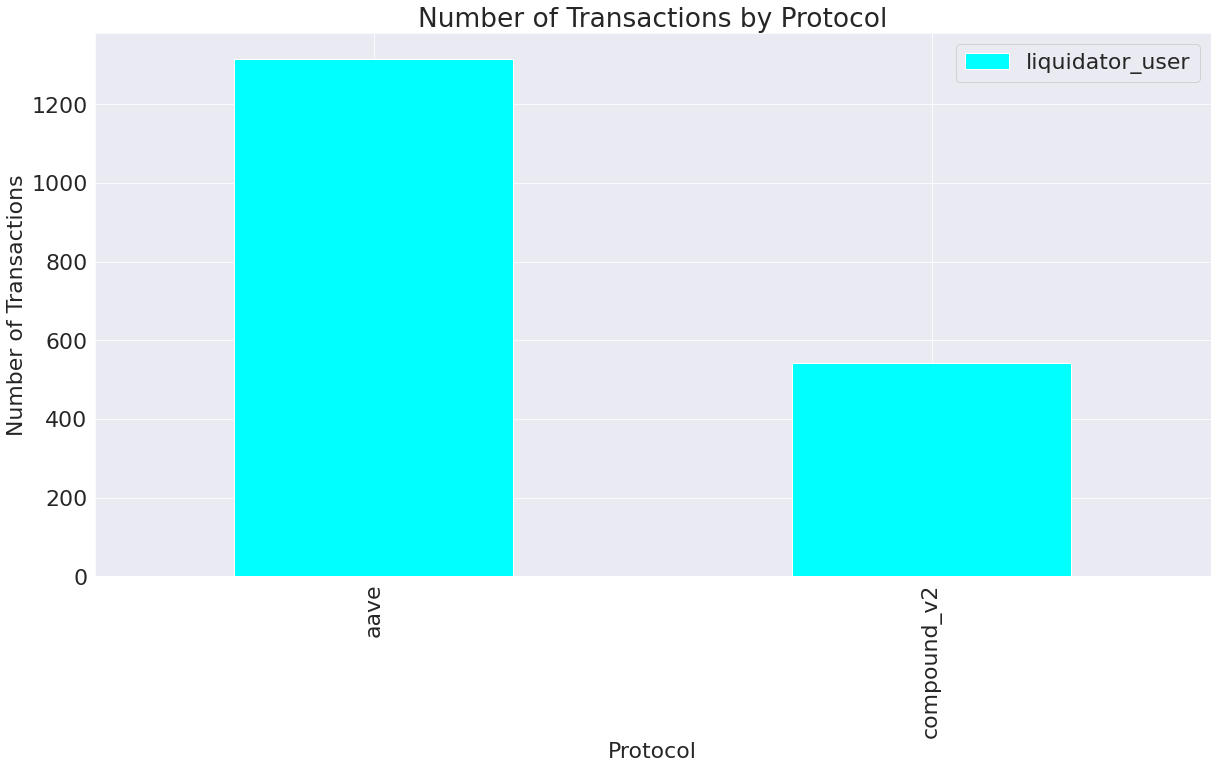

In [82]:
# Parse the protocols column and group by protocol
protocols_df = liquidation_df['protocol'].reset_index(level=0, drop=True).to_frame('protocol')
protocols_df = protocols_df.join(liquidation_df['liquidator_user'].reset_index(level=0, drop=True).to_frame('liquidator_user'))
protocols_df = protocols_df.groupby(['protocol']).count().reset_index()

# Set the figure size and plot the results as a bar chart
_, ax = plt.subplots(figsize=(20, 10))
protocols_df.plot(x='protocol', y='liquidator_user', kind='bar', color='cyan', ax=ax)
plt.title('Number of Transactions by Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Transactions')
plt.show()

In [83]:
liquidation_df['date'] = liquidation_df['timestamp'].dt.date  # extract date part

# filter for desired date
target_date = pd.to_datetime('2022-08-22').date()  # convert to date format
liquidations_on_target_date = liquidation_df[(liquidation_df['date'] == target_date)]

In [84]:
timed_liq_df = liquidations_on_target_date.set_index('timestamp', inplace=False)

def plot_hourly_address_activity(_address, color, _column):
    address_mask = timed_liq_df[_column].str.split(',').apply(lambda x: _address in x)
    address_df = timed_liq_df[address_mask]
    daily_tx_count = address_df.groupby(pd.Grouper(freq='H')).agg({'transaction_hash': 'count'})
    plt.plot(daily_tx_count.index, daily_tx_count['transaction_hash'], color=color)

INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Tether: USDT Stablecoin


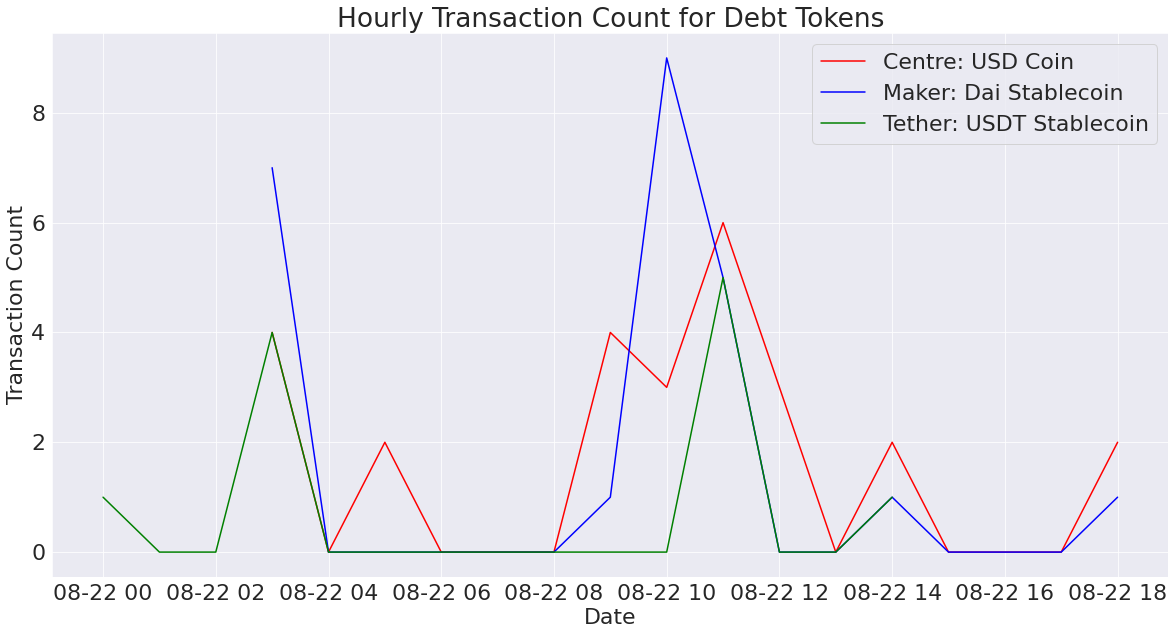

In [85]:
plt.figure(figsize=(20,10))
for i, token in enumerate(liquidations_on_target_date['debt_token_address'].value_counts()[:3].index):
    plot_hourly_address_activity(_address=token, color=colors[i], _column='debt_token_address')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Hourly Transaction Count for Debt Tokens')
tokens_names = _get_name_tags(liquidations_on_target_date['debt_token_address'].value_counts()[:3].index)
plt.legend(tokens_names.values(), loc='best')
plt.show()

INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Already found: Compound: cETH Token


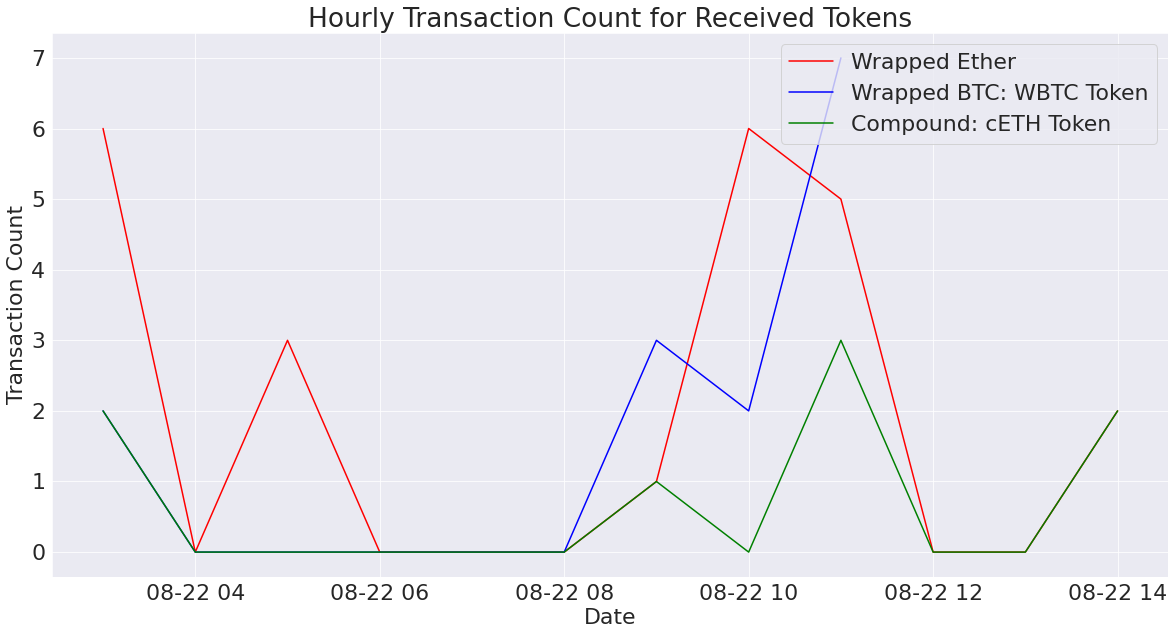

In [86]:
plt.figure(figsize=(20,10))
for i, token in enumerate(liquidations_on_target_date['received_token_address'].value_counts()[:3].index):
    plot_hourly_address_activity(_address=token, color=colors[i], _column='received_token_address')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Hourly Transaction Count for Received Tokens')
tokens_names = _get_name_tags(liquidations_on_target_date['received_token_address'].value_counts()[:3].index)
plt.legend(tokens_names.values(), loc='best')
plt.show()